In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [12]:
df = pd.read_csv("Country-data.csv")
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (167, 10)

First few rows:
               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


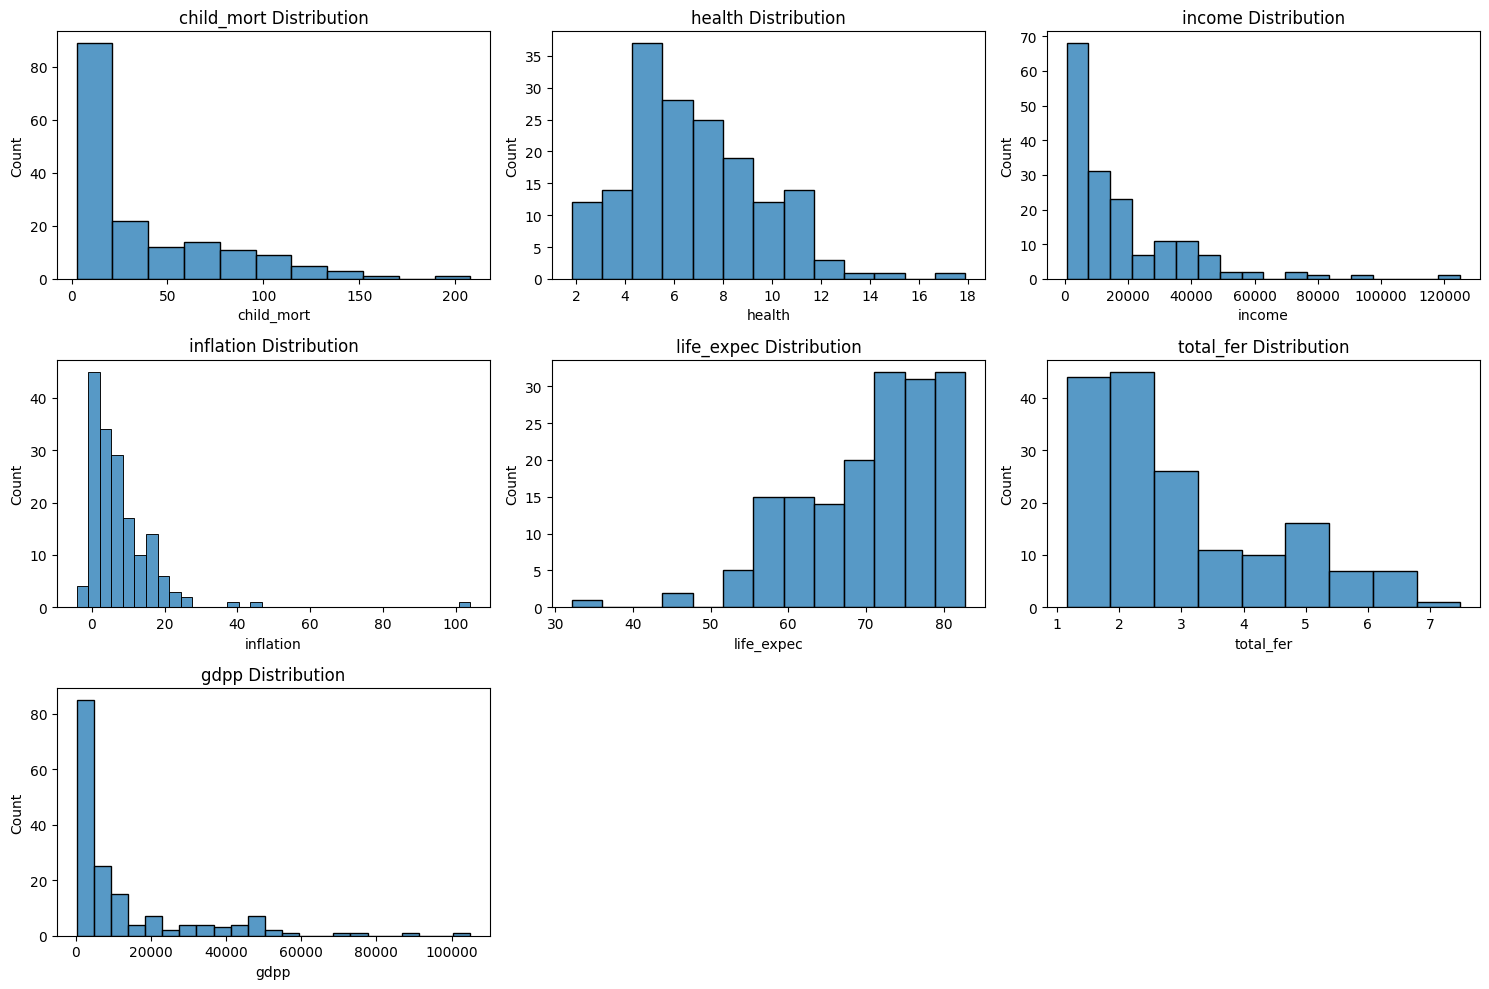

In [13]:
features = [
    "child_mort",
    "health",
    "income",
    "inflation",
    "life_expec",
    "total_fer",
    "gdpp",
]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=feature)
    plt.title(f"{feature} Distribution")
plt.tight_layout()
plt.show()

In [14]:
scaler = StandardScaler()
X = df[features].values
X_scaled = scaler.fit_transform(X)
print("Scaled data shape:", X_scaled.shape)
print("\nMean of scaled features:", np.mean(X_scaled, axis=0))
print("\nStandard deviation of scaled features:", np.std(X_scaled, axis=0))

Scaled data shape: (167, 7)

Mean of scaled features: [-3.72290356e-17  5.50457883e-16 -7.97765048e-17 -1.06368673e-17
  3.69631139e-16  3.04480327e-16  5.85027702e-17]

Standard deviation of scaled features: [1. 1. 1. 1. 1. 1. 1.]


In [15]:
class KMeans:
    def __init__(self, k=4, max_iter=100, n_init=5):
        self.k = k
        self.max_iter = max_iter
        self.n_init = n_init
        self.best_inertia = float("inf")
        self.best_centroids = None
        self.best_labels = None

    def _initialize_centroids(self, X):
        # Randomly select k data points as initial centroids
        indices = np.random.choice(len(X), self.k, replace=False)
        return X[indices]

    def _compute_distance(self, X, centroids):
        # Compute Euclidean distance between points and centroids
        distances = np.zeros((len(X), self.k))
        for k in range(self.k):
            distances[:, k] = np.sum((X - centroids[k]) ** 2, axis=1)
        return distances

    def _assign_clusters(self, distances):
        # Assign points to nearest centroid
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        # Update centroids as mean of assigned points
        new_centroids = np.zeros((self.k, X.shape[1]))
        for k in range(self.k):
            if np.sum(labels == k) > 0:
                new_centroids[k] = np.mean(X[labels == k], axis=0)
        return new_centroids

    def _compute_inertia(self, X, labels, centroids):
        # Compute sum of squared distances to centroids
        inertia = 0
        for k in range(self.k):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - centroids[k]) ** 2)
        return inertia

    def fit(self, X):
        for init in range(self.n_init):
            # Initialize centroids
            centroids = self._initialize_centroids(X)
            prev_labels = None

            for iteration in range(self.max_iter):
                # Assign clusters
                distances = self._compute_distance(X, centroids)
                labels = self._assign_clusters(distances)

                # Check convergence
                if prev_labels is not None and np.array_equal(labels, prev_labels):
                    break

                # Update centroids
                centroids = self._update_centroids(X, labels)
                prev_labels = labels.copy()

            # Compute inertia for this initialization
            inertia = self._compute_inertia(X, labels, centroids)

            # Update best result if better
            if inertia < self.best_inertia:
                self.best_inertia = inertia
                self.best_centroids = centroids
                self.best_labels = labels

        return self


In [16]:
kmeans = KMeans(k=4, max_iter=100, n_init=5)
kmeans.fit(X_scaled)

# Add cluster labels to original dataframe
df["cluster"] = kmeans.best_labels

print(f"Best inertia (within-cluster sum of squares): {kmeans.best_inertia:.2f}")
print("\nCluster sizes:")
print(df["cluster"].value_counts().sort_index())

Best inertia (within-cluster sum of squares): 450.48

Cluster sizes:
cluster
0    85
1    47
2    32
3     3
Name: count, dtype: int64


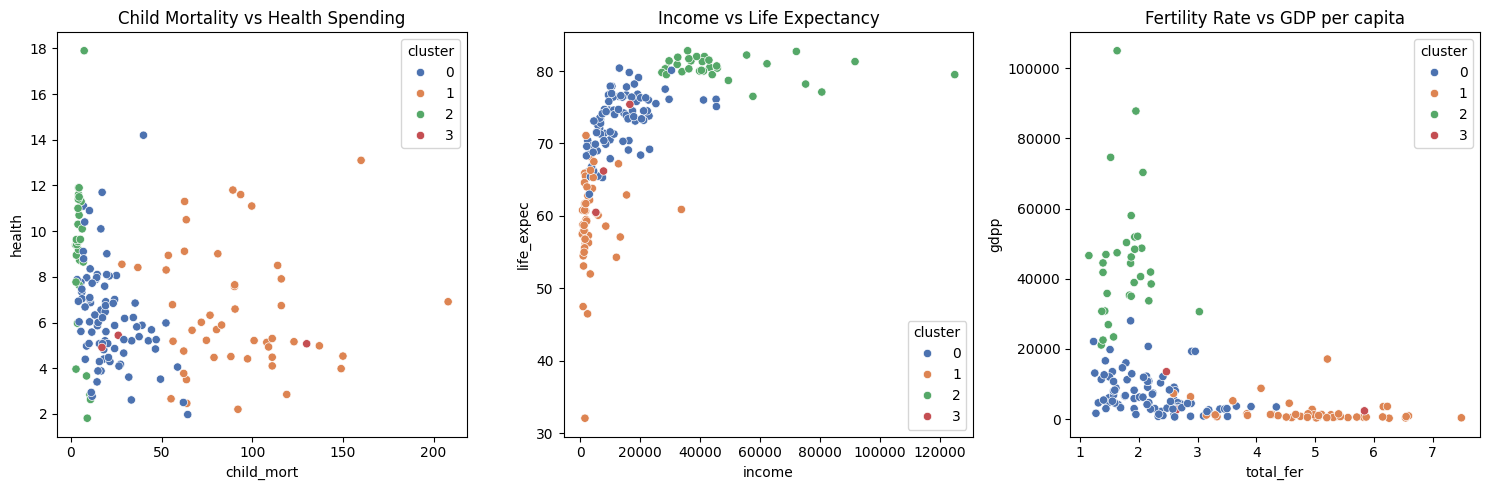

In [17]:
plt.figure(figsize=(15, 5))

# Plot 1: child_mort vs health
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x="child_mort", y="health", hue="cluster", palette="deep")
plt.title("Child Mortality vs Health Spending")

# Plot 2: income vs life_expec
plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x="income", y="life_expec", hue="cluster", palette="deep")
plt.title("Income vs Life Expectancy")

# Plot 3: total_fer vs gdpp
plt.subplot(1, 3, 3)
sns.scatterplot(data=df, x="total_fer", y="gdpp", hue="cluster", palette="deep")
plt.title("Fertility Rate vs GDP per capita")

plt.tight_layout()
plt.show()

In [18]:
print("Cluster Analysis:\n")
for cluster in range(4):
    cluster_data = df[df["cluster"] == cluster]
    print(f"Cluster {cluster}:")
    print(f"Number of countries: {len(cluster_data)}")
    print("\nAverage values of key indicators:")
    print(cluster_data[features].mean())
    print("\nCharacteristic features:")
    # Identify features that are significantly different from the overall mean
    overall_mean = df[features].mean()
    cluster_mean = cluster_data[features].mean()
    significant_features = cluster_mean[
        abs(cluster_mean - overall_mean) > overall_mean.std()
    ]
    print(significant_features)
    print("\n" + "-" * 50 + "\n")


Cluster Analysis:

Cluster 0:
Number of countries: 85

Average values of key indicators:
child_mort       21.102353
health            6.241765
income        13325.647059
inflation         6.543776
life_expec       73.202353
total_fer         2.244824
gdpp           7136.729412
dtype: float64

Characteristic features:
Series([], dtype: float64)

--------------------------------------------------

Cluster 1:
Number of countries: 47

Average values of key indicators:
child_mort      90.793617
health           6.462553
income        3870.702128
inflation        9.951809
life_expec      59.212766
total_fer        4.974043
gdpp          1900.255319
dtype: float64

Characteristic features:
income    3870.702128
gdpp      1900.255319
dtype: float64

--------------------------------------------------

Cluster 2:
Number of countries: 32

Average values of key indicators:
child_mort        4.903125
health            9.015937
income        47475.000000
inflation         2.703437
life_expec       8